# Horse Race Prediction with Regression Models

In [728]:
# Basic Libraries
import numpy as np
import pandas as pd
import json
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

from sklearn.preprocessing import LabelEncoder # used for label encoding
import category_encoders as ce # used for target encoding
from sklearn.model_selection import train_test_split #split data into train and test sets
from sklearn import linear_model # linear regression model
from sklearn.linear_model import LogisticRegression # logistic regression model
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix # evaluate goodness of fit

## 1. Data Pre-Processing

### 1.1 Creating Dataframe
- We first create our dataframe containing all uncleaned data from our json file. 
- The data was obtained through scraping Singapore Turf Club website using Selenum.

In [729]:
# Load JSON data from file
with open('Selenium Scraping\horse_profiles.json', 'r') as f:
    json_data = json.load(f)

# Create DataFrame from JSON data
df = pd.DataFrame(json_data)

df

,HorseName,Barrier,CarriedWeight,Distance,Placing,Rating,HorseWeight,Going,Track,Jockey,Trainer,LBW,Finish Time
0,A BETTER TOMORROW,4,58.0,1700,2/12,46,476,G,P,R CURATOLO,J PETERS,4.3,1:47.05
1,A BETTER TOMORROW,11,58.0,1600,1/11,42,483,G,T,R CURATOLO,J PETERS,2.0,1:36.23
2,A BETTER TOMORROW,8,55.0,1400,4/10,43,483,G,T,APP S JAMIL,J PETERS,2.3,1:23.08
3,A BETTER TOMORROW,8,55.0,1400,3/12,43,475,G,T,APP S JAMIL,J PETERS,2.0,1:24.39
4,A BETTER TOMORROW,4,57.5,1600,9/10,45,477,G,P,R WOODWORTH,J PETERS,7.6,1:41.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41130,ZYGARDE,9,57.0,1200,8/11,,526,G,T,D MOOR,KS TAN,11.8,1:12.57
41131,ZYGARDE,4,63.0,1000,2/4,,,G,P,D MOOR,KS TAN,4.3,1:04.29
41132,ZYGARDE,6,57.0,1000,3/12,,540,G,P,D MOOR,KS TAN,0.7,0:59.65
41133,ZYGARDE,4,61.0,1000,3/4,,,G,P,D MOOR,KS TAN,6.3,1:03.79


### 1.2 Data Cleaning

### 1.2.1 Filtering out missing rows
- Since we already have ~40k rows in our dataframe, we are not lacking in the number of datapoints. 
- There is no need to replace missing data with the average. In fact, this might even compromise the integrity of the data, considering there are many rows with missing data.
- Even after removing rows with missing data, there is still ~15k complete rows remaining.

In [730]:
filterCols = []

for column in df.columns:
    empty_string_count = (df[column] == "").sum()
    print("Number of empty strings in", column, ":", empty_string_count)
    if(empty_string_count>0):
        filterCols.append(column)
        
print("\nColumns to filter",filterCols)

Number of empty strings in HorseName : 0
Number of empty strings in Barrier : 0
Number of empty strings in CarriedWeight : 5636
Number of empty strings in Distance : 0
Number of empty strings in Placing : 0
Number of empty strings in Rating : 3357
Number of empty strings in HorseWeight : 7762
Number of empty strings in Going : 3
Number of empty strings in Track : 0
Number of empty strings in Jockey : 36
Number of empty strings in Trainer : 2
Number of empty strings in LBW : 54
Number of empty strings in Finish Time : 16222

Columns to filter ['CarriedWeight', 'Rating', 'HorseWeight', 'Going', 'Jockey', 'Trainer', 'LBW', 'Finish Time']


In [731]:
mask = pd.Series(True, index=df.index)

for col in filterCols:
    mask = mask & (df[col] != "")

mask = mask & (df["Finish Time"]!="0")
filtered_df = df[mask]

for column in filtered_df.columns:
    empty_string_count = (filtered_df[column] == "").sum()
    print("Number of empty strings in", column, ":", empty_string_count)
    if(empty_string_count>0):
        filterCols.append(column)

filtered_df

Number of empty strings in HorseName : 0
Number of empty strings in Barrier : 0
Number of empty strings in CarriedWeight : 0
Number of empty strings in Distance : 0
Number of empty strings in Placing : 0
Number of empty strings in Rating : 0
Number of empty strings in HorseWeight : 0
Number of empty strings in Going : 0
Number of empty strings in Track : 0
Number of empty strings in Jockey : 0
Number of empty strings in Trainer : 0
Number of empty strings in LBW : 0
Number of empty strings in Finish Time : 0


,HorseName,Barrier,CarriedWeight,Distance,Placing,Rating,HorseWeight,Going,Track,Jockey,Trainer,LBW,Finish Time
0,A BETTER TOMORROW,4,58.0,1700,2/12,46,476,G,P,R CURATOLO,J PETERS,4.3,1:47.05
1,A BETTER TOMORROW,11,58.0,1600,1/11,42,483,G,T,R CURATOLO,J PETERS,2.0,1:36.23
2,A BETTER TOMORROW,8,55.0,1400,4/10,43,483,G,T,APP S JAMIL,J PETERS,2.3,1:23.08
3,A BETTER TOMORROW,8,55.0,1400,3/12,43,475,G,T,APP S JAMIL,J PETERS,2.0,1:24.39
4,A BETTER TOMORROW,4,57.5,1600,9/10,45,477,G,P,R WOODWORTH,J PETERS,7.6,1:41.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41123,ZYGARDE,5,59.0,1700,5/12,48,520,G,P,M LERNER,KS TAN,5.9,1:46.56
41124,ZYGARDE,2,58.0,1600,5/12,48,526,G,P,S NOH,KS TAN,7.5,1:39.67
41125,ZYGARDE,10,58.5,1200,1/12,43,529,G,P,M LERNER,KS TAN,0.5,1:12.46
41126,ZYGARDE,4,57.5,1200,7/12,45,525,G,P,M LERNER,KS TAN,8.8,1:12.94


### 1.2.2 Formatting  numeric columns / categorical columns that contain numbers
- The scraped data has a datatype of 'string' object for all variables, which needs to be converted to 'float'

- The numeric columns need to be properly formatted for EDA and our Regression models
    - `Finish Time` needs to be reformatted from mm:ss.ms to just seconds
    - `Placing` needs to be reformatted from XX/YY to XX
    


In [732]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15755 entries, 0 to 41127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   HorseName      15755 non-null  object
 1   Barrier        15755 non-null  object
 2   CarriedWeight  15755 non-null  object
 3   Distance       15755 non-null  object
 4   Placing        15755 non-null  object
 5   Rating         15755 non-null  object
 6   HorseWeight    15755 non-null  object
 7   Going          15755 non-null  object
 8   Track          15755 non-null  object
 9   Jockey         15755 non-null  object
 10  Trainer        15755 non-null  object
 11  LBW            15755 non-null  object
 12  Finish Time    15755 non-null  object
dtypes: object(13)
memory usage: 1.7+ MB


In [733]:
numericCols = ['CarriedWeight','Distance','Rating', 'HorseWeight','LBW','Barrier']

for col in numericCols:
    filtered_df[col] = filtered_df[col].astype(float)
    
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15755 entries, 0 to 41127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HorseName      15755 non-null  object 
 1   Barrier        15755 non-null  float64
 2   CarriedWeight  15755 non-null  float64
 3   Distance       15755 non-null  float64
 4   Placing        15755 non-null  object 
 5   Rating         15755 non-null  float64
 6   HorseWeight    15755 non-null  float64
 7   Going          15755 non-null  object 
 8   Track          15755 non-null  object 
 9   Jockey         15755 non-null  object 
 10  Trainer        15755 non-null  object 
 11  LBW            15755 non-null  float64
 12  Finish Time    15755 non-null  object 
dtypes: float64(6), object(7)
memory usage: 1.7+ MB


C:\Users\Wahaj\AppData\Local\Temp\ipykernel_13204\3989451750.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[col] = filtered_df[col].astype(float)
C:\Users\Wahaj\AppData\Local\Temp\ipykernel_13204\3989451750.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[col] = filtered_df[col].astype(float)
C:\Users\Wahaj\AppData\Local\Temp\ipykernel_13204\3989451750.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [734]:
# Function to convert mm:ss format to continuous numeric value
def mmss_to_seconds(time_str):
    if isinstance(time_str, str) and ':' in time_str:
        minutes, seconds = map(float, time_str.split(':'))
        return minutes * 60 + seconds
    else:
        return None 

# Apply the function to the Finish Time column
filtered_df['FinishTime_Numeric'] = filtered_df['Finish Time'].apply(mmss_to_seconds)

C:\Users\Wahaj\AppData\Local\Temp\ipykernel_13204\3793603269.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['FinishTime_Numeric'] = filtered_df['Finish Time'].apply(mmss_to_seconds)


In [735]:
# Convert XX/YY placing format to numeric
def placing(place_str):
    if isinstance(place_str, str) and '/' in place_str: 
        place,total = map(int, place_str.split('/'))
        return place
    else:
        return None

filtered_df['Placing_Numeric'] = filtered_df['Placing'].apply(placing)

C:\Users\Wahaj\AppData\Local\Temp\ipykernel_13204\1526986524.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Placing_Numeric'] = filtered_df['Placing'].apply(placing)


No issues in conversion

In [736]:
filtered_df.isna().sum()

HorseName             0
Barrier               0
CarriedWeight         0
Distance              0
Placing               0
Rating                0
HorseWeight           0
Going                 0
Track                 0
Jockey                0
Trainer               0
LBW                   0
Finish Time           0
FinishTime_Numeric    0
Placing_Numeric       0
dtype: int64

### 1.3 Feature Engineering for possibly better correlation
- We chose to also engineer a variable that will measure the ratio of the rider's weight to the horse's weight.
- We will need to do EDA to determine if our initial hypothesis that this feature will be useful in regression is correct.

In [737]:
filtered_df['WeightRatio'] = filtered_df['CarriedWeight']/filtered_df['HorseWeight']

C:\Users\Wahaj\AppData\Local\Temp\ipykernel_13204\1646073771.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['WeightRatio'] = filtered_df['CarriedWeight']/filtered_df['HorseWeight']


## 2. Exploratory Data Analysis + Further Data Pre-Processing (from EDA insights)

### 2.1.1 Exploring Numeric Variables

In [738]:
predictors = ['WeightRatio','CarriedWeight', 'Distance','Rating', 'HorseWeight']

In [739]:
def plot_correlation(filtered_df, response_variable):
    # Selecting the relevant columns
    X = filtered_df[predictors] 

    # Select the response variable
    y = filtered_df[response_variable]

    # Concatenate predictor variables with response variable
    data = pd.concat([X, y], axis=1)

    # Compute correlation matrix
    correlation_matrix = data.corr()

    # Slice the correlation matrix to include only the last row
    correlation_with_response = correlation_matrix.iloc[-1, :-1]

    # Plot correlation with response variable
    plt.figure(figsize=(10, 6))
    sb.barplot(x=correlation_with_response.index, y=correlation_with_response.values)
    plt.title(f'Correlation with {response_variable}')
    plt.xlabel('Predictor Variables')
    plt.ylabel('Correlation')
    plt.xticks(rotation=45)
    plt.show()


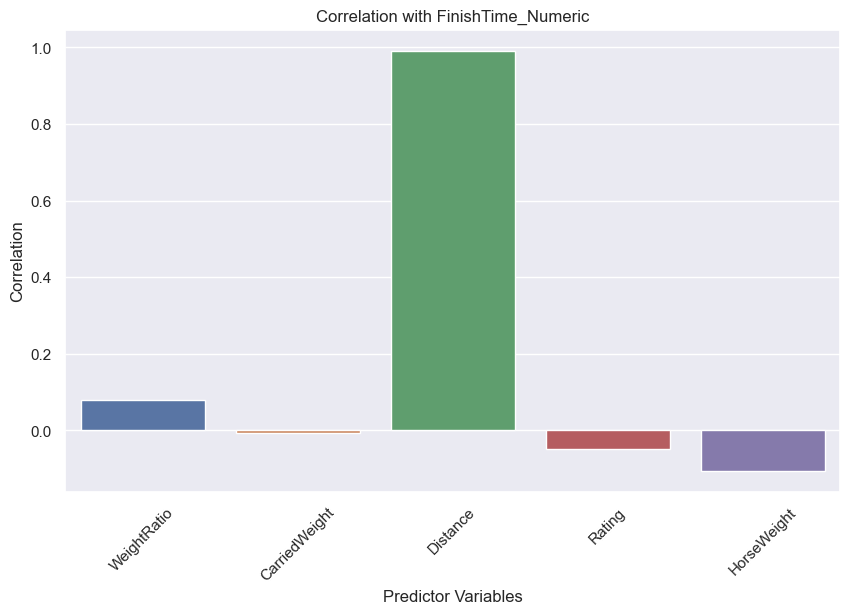

In [740]:
plot_correlation(filtered_df, 'FinishTime_Numeric')

### 2.1.2 Distance as a dominant variable

`Distance` has almost 1:1 correlation with `FinishTime_Numeric`. 

We learned `Distance` will be a strongly dominating variable if it is used in regression models. 
- It would have a disproportionate influence on regression models. Thereby, sidelining the other variables which might be more relevant in predicting the horse's performance.

As such, we will be choosing only one distance to work on, which is 1200m, as it is the most common distance for horse races.

In [741]:
filtered_df['Distance'].value_counts()

Distance
1200.0    5808
1400.0    3101
1600.0    2376
1100.0    1763
1000.0    1393
1700.0     522
1800.0     482
2000.0     308
2200.0       1
1900.0       1
Name: count, dtype: int64

In [742]:
filtered_df = filtered_df[filtered_df['Distance']==1200]
filtered_df.shape

(5808, 16)

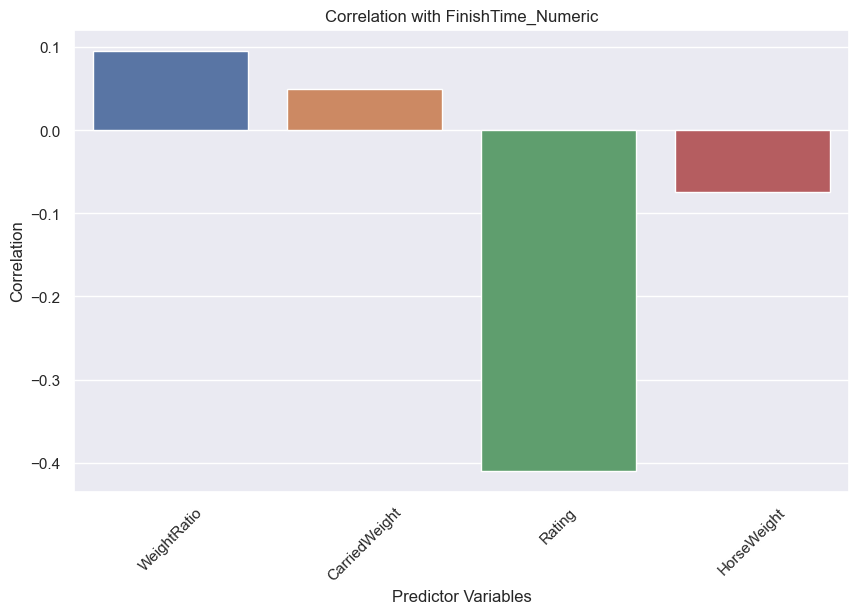

In [743]:
predictors = ['WeightRatio','CarriedWeight','Rating', 'HorseWeight']
plot_correlation(filtered_df, 'FinishTime_Numeric')

### 2.1.3 Checking for colinearity

- Also, from the correlation matrix, other than `Carried Weight` <-> `WeightRatio` we can see that the predictors also generally have low correlation with each other. As such, we do not have to worry about the issue of multicollinearity, which may lead to unreliable estimates.

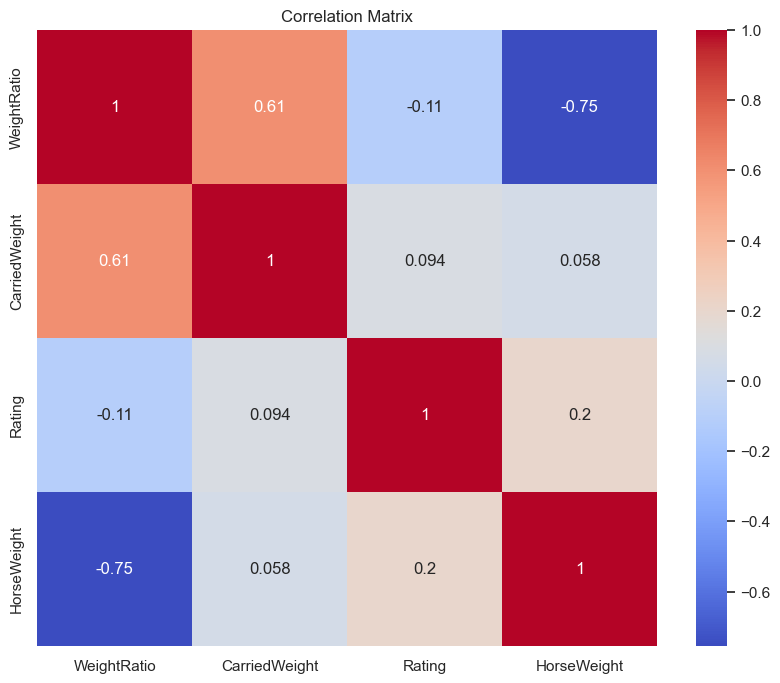

In [744]:
correlation_matrix = filtered_df[['WeightRatio','CarriedWeight', 'Rating', 'HorseWeight']] .corr()
plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### 2.2.1 Exploring Response Variable `Finish Time_Numeric`

In [745]:
def createBoxPlot():
    plt.figure(figsize=(10, 6))
    sb.boxplot(x=filtered_df['FinishTime_Numeric'])
    plt.title('Boxplot of FinishTime_Numeric')
    plt.xlabel('FinishTime_Numeric')
    plt.show()
    
def createHistogramWithKDE():
    plt.figure(figsize=(10, 6))
    sb.histplot(filtered_df['FinishTime_Numeric'], kde=True)
    plt.title('Histogram with KDE of FinishTime_Numeric')
    plt.xlabel('FinishTime_Numeric')
    plt.ylabel('Density')
    plt.show()

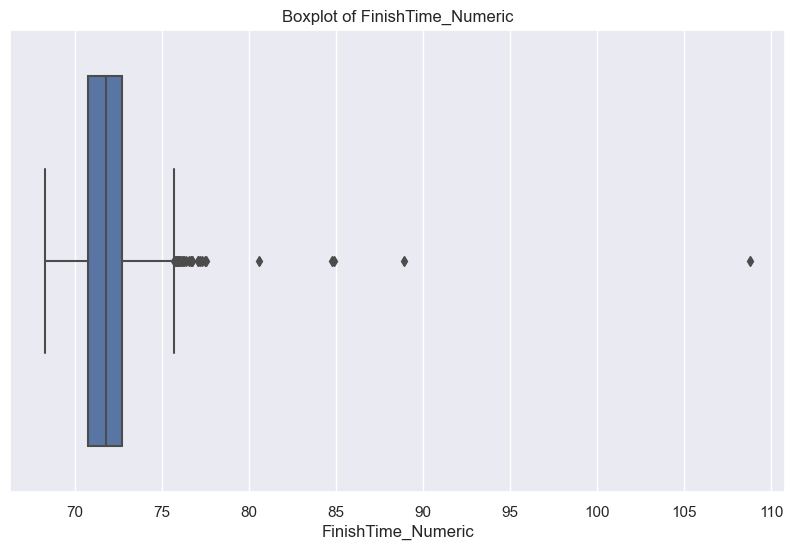

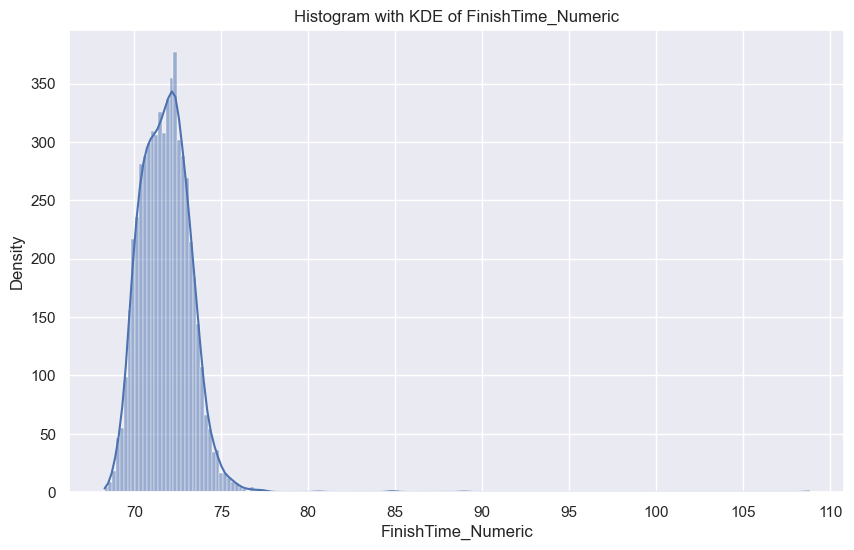

In [746]:
createBoxPlot()
createHistogramWithKDE()

### 2.2.2 Getting Rid of Outliers in Response Variable `Finish Time_Numeric`

In [747]:
# Calculate the first quartile (Q1) and third quartile (Q3)
Q1 = filtered_df['FinishTime_Numeric'].quantile(0.25)
Q3 = filtered_df['FinishTime_Numeric'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Drop outliers from 'FinishTime_Numeric'
filtered_df = filtered_df[(filtered_df['FinishTime_Numeric'] >= lower_bound) & (filtered_df['FinishTime_Numeric'] <= upper_bound)]

# Print the DataFrame without outliers
filtered_df.shape


(5775, 16)

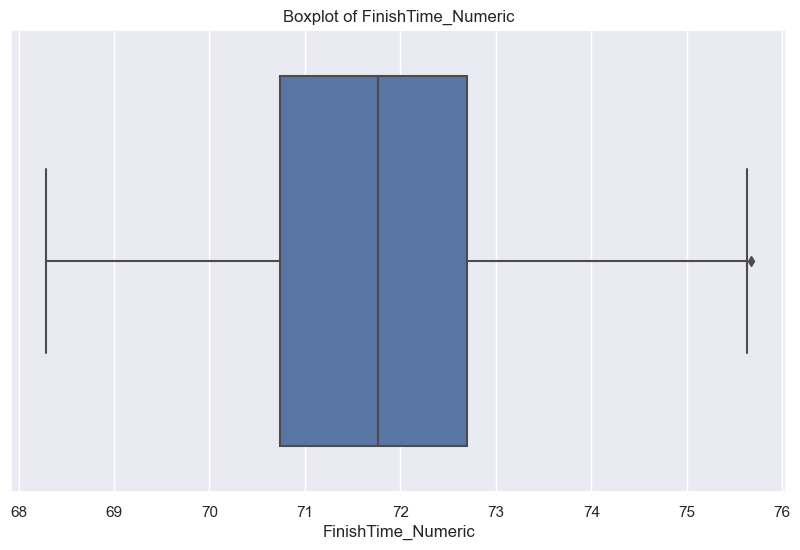

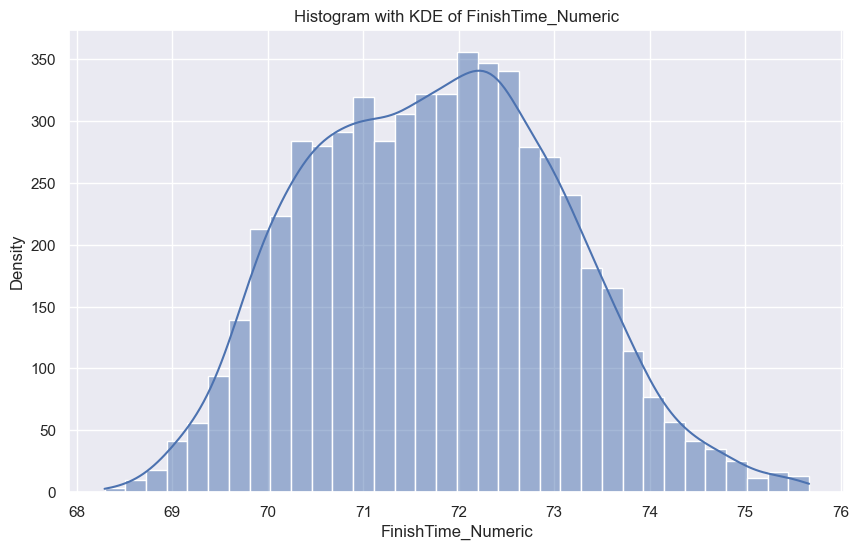

In [748]:
createBoxPlot()
createHistogramWithKDE()

### 2.3.1 Exploring Categorical Variables A (`Barrier`, `Going`, `Track`)
- Category A variables are variables that can be encoded with One Hot Encoding as they have very little different values.

In [749]:
import matplotlib.pyplot as plt

def catBoxPlot(categorical_variable):
    # Assuming filtered_df is your DataFrame containing the data
    # Draw boxplots for 'FinishTime_Numeric' grouped by 'Barrier'
    fig, ax = plt.subplots(figsize=(10, 6))
    filtered_df.boxplot(column='FinishTime_Numeric', by=categorical_variable, ax=ax)
    plt.title('Boxplot of FinishTime_Numeric grouped by ' + categorical_variable)
    plt.xlabel(categorical_variable)
    plt.ylabel('FinishTime_Numeric')

    # Manually set the scale of the y-axis
#     ax.set_ylim(70,75)  # Adjust the limits as needed

    plt.show()


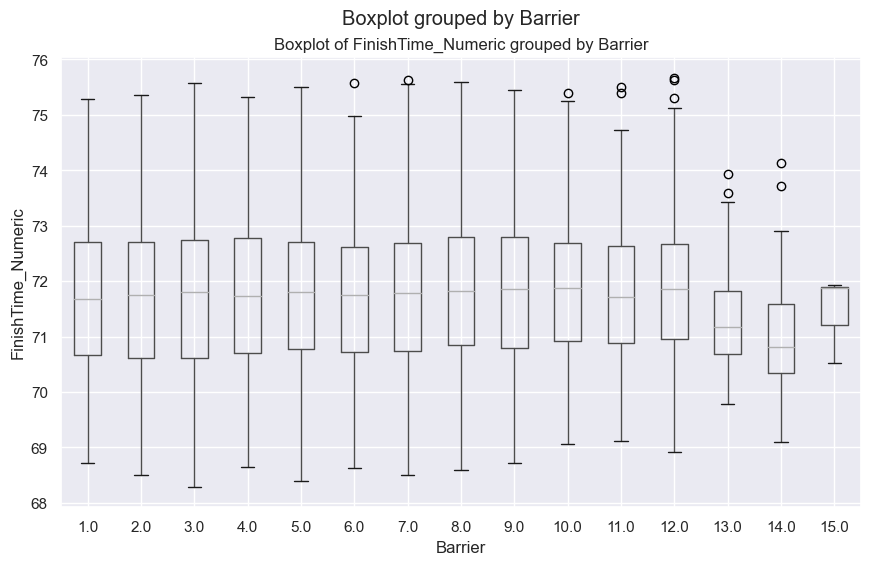

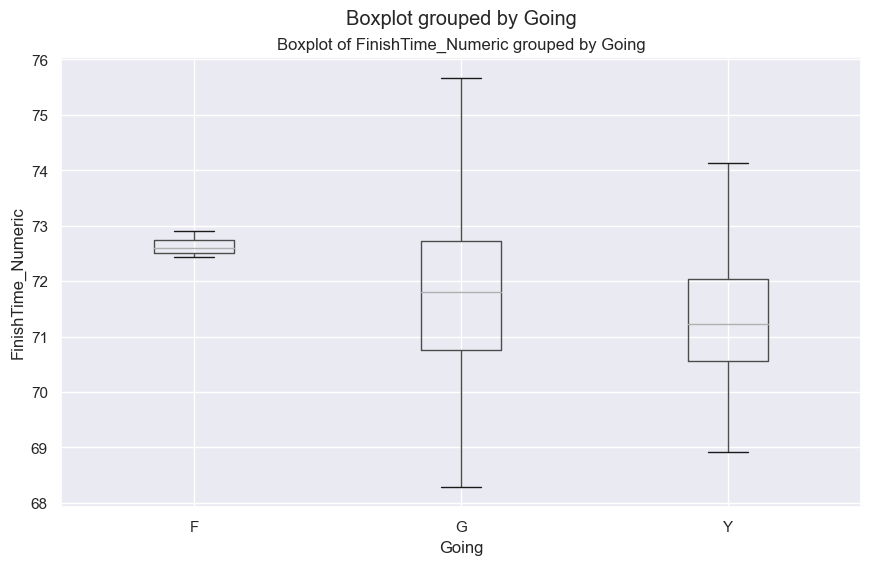

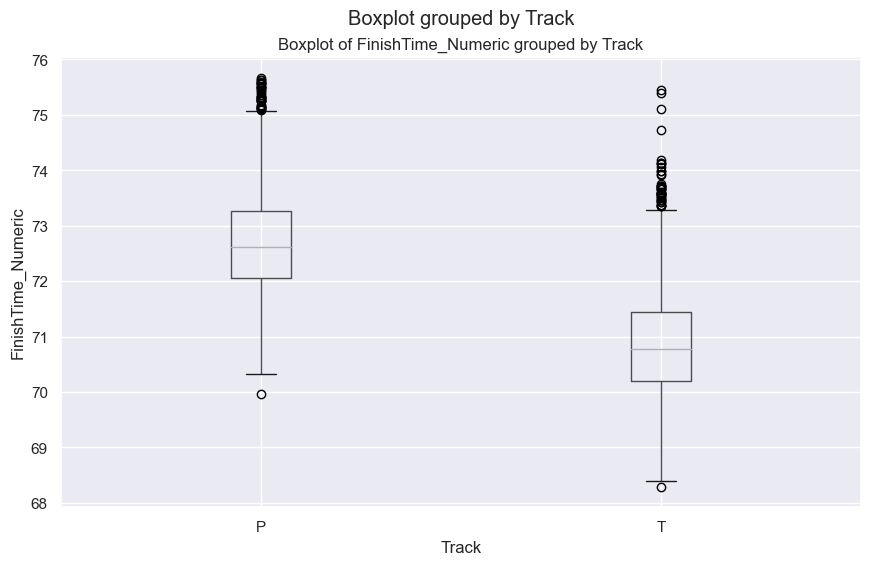

In [750]:
catBoxPlot('Barrier')
catBoxPlot('Going')
catBoxPlot('Track')

### 2.3.2 One-Hot Encoding `Track`

In [751]:
one_hot_encoded = pd.get_dummies(filtered_df['Track'], prefix='Track').astype(int)

# Concatenate the one-hot encoded columns with the original DataFrame
filtered_df = pd.concat([filtered_df, one_hot_encoded], axis=1)

filtered_df

,HorseName,Barrier,CarriedWeight,Distance,Placing,Rating,HorseWeight,Going,Track,Jockey,Trainer,LBW,Finish Time,FinishTime_Numeric,Placing_Numeric,WeightRatio,Track_P,Track_T
10,A BETTER TOMORROW,13.0,57.5,1200.0,8/13,55.0,472.0,G,T,R WOODWORTH,J PETERS,12.2,1:11.74,71.74,8,0.121822,0,1
11,A BETTER TOMORROW,4.0,57.5,1200.0,3/12,55.0,470.0,G,P,R WOODWORTH,J PETERS,1.0,1:13.20,73.20,3,0.122340,1,0
26,ACE OF DIAMONDS,8.0,57.0,1200.0,1/9,67.0,514.0,G,T,B QUEIROZ,R LE GRANGE,1.0,1:09.57,69.57,1,0.110895,0,1
34,ACE OF DIAMONDS,13.0,57.0,1200.0,1/14,46.0,513.0,G,T,B PINHEIRO,R LE GRANGE,3.3,1:10.43,70.43,1,0.111111,0,1
45,ACE SOVEREIGN,5.0,51.0,1200.0,6/10,55.0,529.0,G,T,APP R AZHAR,T FITZSIMMONS,4.1,1:09.93,69.93,6,0.096408,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41114,ZYGARDE,1.0,51.0,1200.0,2/14,48.0,519.0,Y,T,JP VAN DER MERWE,KS TAN,4.3,1:10.73,70.73,2,0.098266,0,1
41115,ZYGARDE,10.0,51.0,1200.0,2/12,48.0,518.0,Y,T,JP VAN DER MERWE,KS TAN,0.5,1:11.21,71.21,2,0.098456,0,1
41121,ZYGARDE,9.0,56.5,1200.0,2/12,45.0,520.0,G,T,S NOH,KS TAN,1.5,1:10.68,70.68,2,0.108654,0,1
41125,ZYGARDE,10.0,58.5,1200.0,1/12,43.0,529.0,G,P,M LERNER,KS TAN,0.5,1:12.46,72.46,1,0.110586,1,0


### 2.4.1 Exploring Categorical Variables B (`HorseName`, `Jockey`, `Trainer`)
- Category B variables are handled separately with target encoding because of its huge number of unique values.
- The target variable chosen is LBW (Length Behind Winner) as LBW is highly correlated to placing.

In [752]:
catB = ['HorseName', 'Jockey', 'Trainer']
for cat in catB:
    print(f"No. of unique values in {cat}: {filtered_df[cat].nunique()}")

No. of unique values in HorseName: 726
No. of unique values in Jockey: 119
No. of unique values in Trainer: 36


### 2.4.2 Picking target value to encode Categorical Variables B
- Target Encoding works by replacing categorical variables with the mean of the target variable for each category. In this case, we have used Lengths Behind Winner (LBW) as the target variable. We chose LBW as it is a good indicator of the horse's performance in a race.

In [753]:
def targetEncoder(var, new_col,target):
    # Initialize the TargetEncoder
    target_encoder = ce.TargetEncoder(cols=[var])

    # Fit and transform the DataFrame to perform target encoding
    filtered_df[new_col] = target_encoder.fit_transform(filtered_df[var], filtered_df[target])

**We can observe that LBW is highly correlated to the performance of a horse in terms of its placing.**

As such, we chose LBW as the target variable during target encoding, as mentioned earlier.

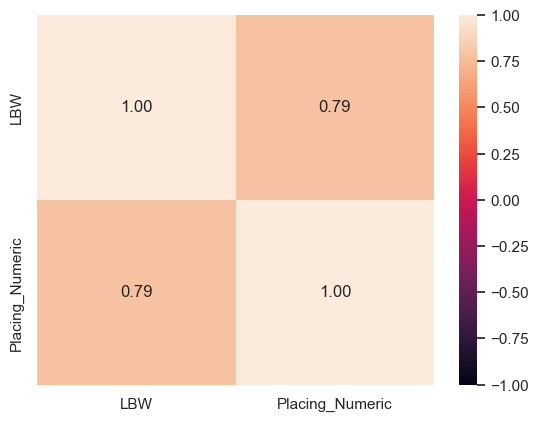

In [754]:
correlation_matrix = filtered_df[['LBW', 'Placing_Numeric']].corr()

sb.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.show()

### 2.4.3 Target Encoding Categorical Variables B

In [755]:
target = 'LBW'
for cat in catB:
    targetEncoder(cat,('encoded_'+cat),target)


### 2.5 Dropping unrequired variables, and reordering the rest

In [756]:
drop_cols = ['Finish Time','Barrier','CarriedWeight','Distance','Placing','Going','Track']

In [757]:
# Drop the specified columns from the DataFrame
filtered_df.drop(columns=drop_cols, inplace=True)
desired_order = ['HorseName', 'encoded_HorseName','Rating', 'HorseWeight','WeightRatio', 'Jockey', 'encoded_Jockey', 'Trainer', 'encoded_Trainer','Track_P','Track_T','Placing_Numeric','LBW','FinishTime_Numeric']

# Reorder columns in the DataFrame
filtered_df = filtered_df[desired_order]

In [758]:
filtered_df

,HorseName,encoded_HorseName,Rating,HorseWeight,WeightRatio,Jockey,encoded_Jockey,Trainer,encoded_Trainer,Track_P,Track_T,Placing_Numeric,LBW,FinishTime_Numeric
10,A BETTER TOMORROW,5.070608,55.0,472.0,0.121822,R WOODWORTH,4.408065,J PETERS,4.632024,0,1,8,12.2,71.74
11,A BETTER TOMORROW,5.070608,55.0,470.0,0.122340,R WOODWORTH,4.408065,J PETERS,4.632024,1,0,3,1.0,73.20
26,ACE OF DIAMONDS,4.439370,67.0,514.0,0.110895,B QUEIROZ,2.639010,R LE GRANGE,4.312451,0,1,1,1.0,69.57
34,ACE OF DIAMONDS,4.439370,46.0,513.0,0.111111,B PINHEIRO,4.233733,R LE GRANGE,4.312451,0,1,1,3.3,70.43
45,ACE SOVEREIGN,4.596435,55.0,529.0,0.096408,APP R AZHAR,5.593429,T FITZSIMMONS,4.551032,0,1,6,4.1,69.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41114,ZYGARDE,4.019932,48.0,519.0,0.098266,JP VAN DER MERWE,4.871340,KS TAN,5.025140,0,1,2,4.3,70.73
41115,ZYGARDE,4.019932,48.0,518.0,0.098456,JP VAN DER MERWE,4.871340,KS TAN,5.025140,0,1,2,0.5,71.21
41121,ZYGARDE,4.019932,45.0,520.0,0.108654,S NOH,3.992335,KS TAN,5.025140,0,1,2,1.5,70.68
41125,ZYGARDE,4.019932,43.0,529.0,0.110586,M LERNER,4.352045,KS TAN,5.025140,1,0,1,0.5,72.46


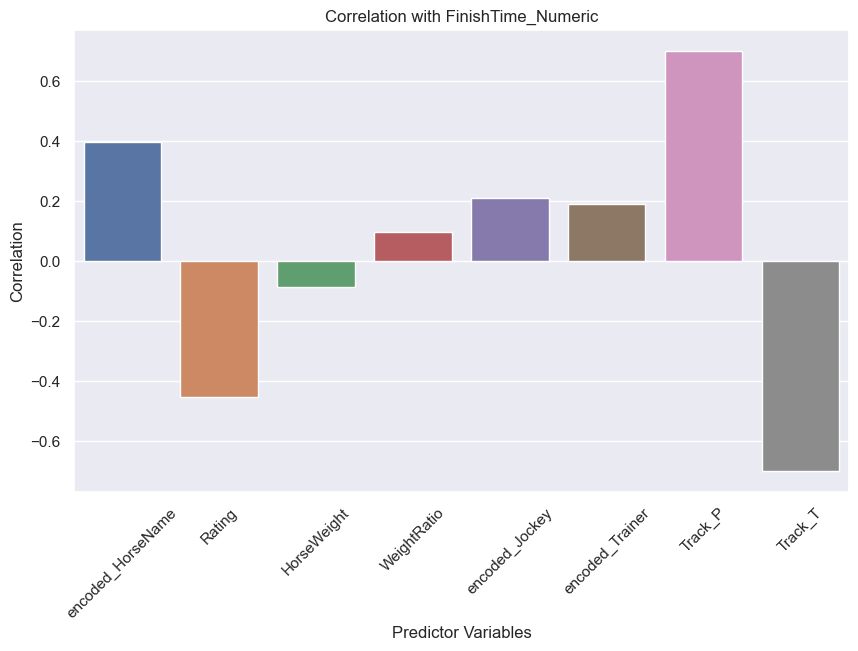

In [759]:
predictors = ['encoded_HorseName','Rating', 'HorseWeight','WeightRatio', 'encoded_Jockey', 'encoded_Trainer','Track_P','Track_T']
plot_correlation(filtered_df, 'FinishTime_Numeric')

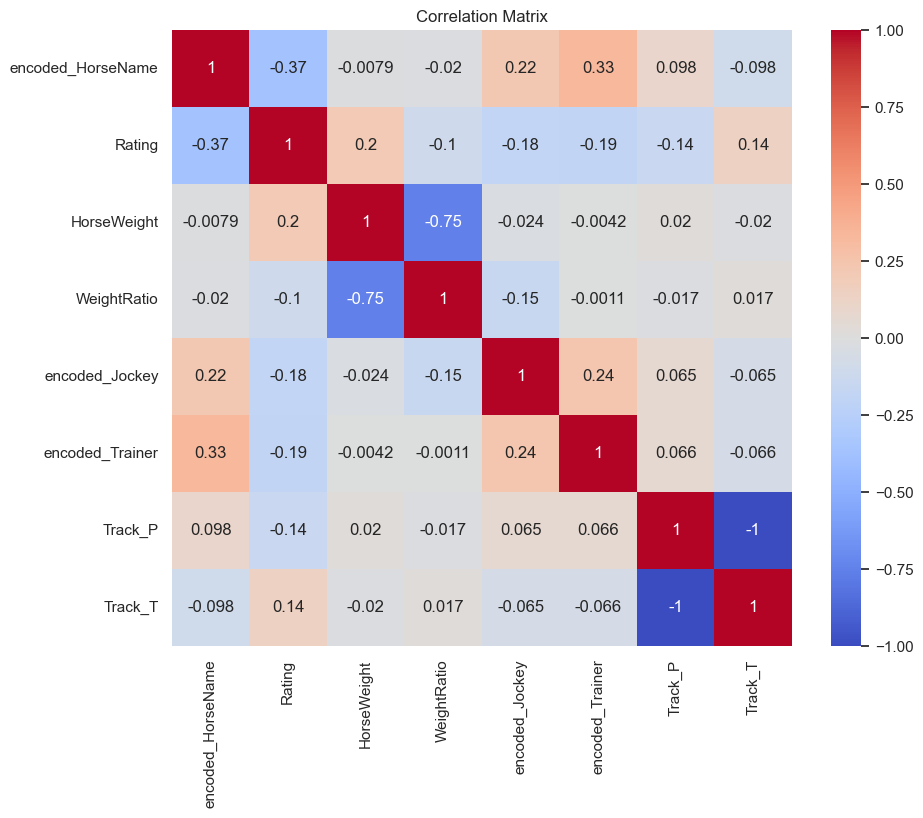

In [760]:
correlation_matrix = filtered_df[predictors] .corr()
plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## 3.1 Linear Regression Analysis for Predicting Finish Time

In this analysis, we use linear regression to predict the finish time of horse races based on various predictors. Below are the key components and insights from the analysis:

#### Predictors and Response Variable

- **Predictors (X)**: We use the following features as predictors:
  - `encoded_HorseName`: Encoded representation of the horse's name
  - `Barrier`: Barrier number
  - `CarriedWeight`: Weight carried by the horse
  - `Rating`: Horse rating
  - `HorseWeight`: Weight of the horse
  - `encoded_Going`: Encoded representation of track condition (Going)
  - `encoded_Track`: Encoded representation of the track
  - `encoded_Jockey`: Encoded representation of the jockey
  - `encoded_Trainer`: Encoded representation of the trainer

- **Response Variable (y)**: The response variable is `FinishTime_Seconds`, representing the finish time of the each horse in seconds.

#### Data Splitting

- We split the dataset into training and testing sets using a 75/25 ratio.

#### Evaluation

- **Goodness of Fit**:
  - Explained Variance (R^2): Measuring fit
  - Mean Squared Error (MSE): Measuring error

#### Insights
- We have a decent R^2 of ~0.69 and an MSE of ~0.53 for the test data set

- An MSE of 0.53 indicates that our model is fairly accurate, as the root mean square error is ~0.72. An RMSE of 0.72 means that, on average, the difference between the predicted values and the actual values is 0.72 seconds. However, while the model is accurate, it isn't ideal since the difference between horses' is on the order of tenths of a second. However, it is a decent starting point.


In [761]:
#predictors
X = filtered_df[predictors]

#response
y = filtered_df[['FinishTime_Numeric']] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

print("x_train shape :", X_train.shape)
print("y_train shape :", y_train.shape)
print("x_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)

linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

x_train shape : (4331, 8)
y_train shape : (4331, 1)
x_test shape : (1444, 8)
y_test shape : (1444, 1)


LinearRegression()

In [762]:
# Predict Finish Time for both Train and Test Data Sets
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.6758327279690345
Mean Squared Error (MSE) 	: 0.5600624246012865



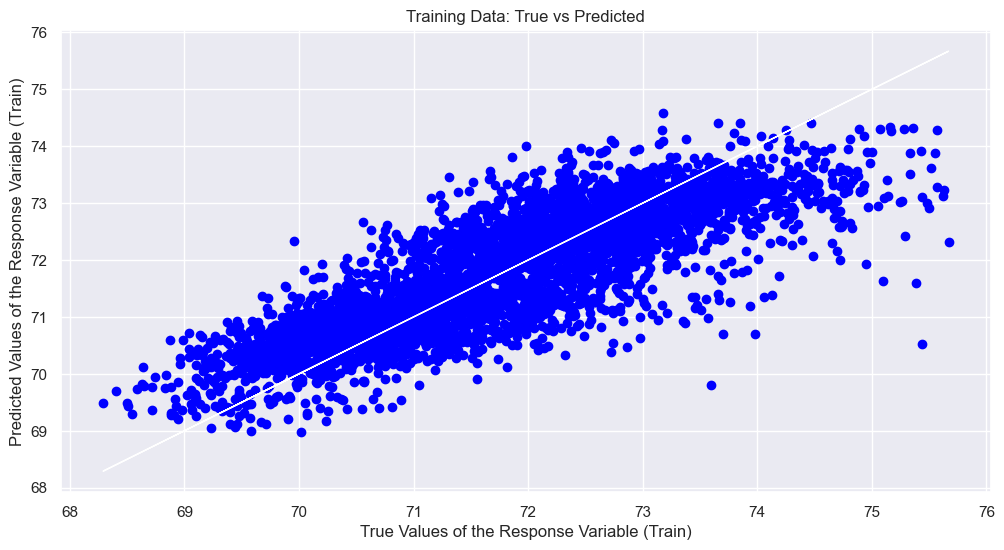

In [763]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Plot for training data
plt.figure(figsize=(12, 6))
plt.scatter(y_train, y_train_pred, color="blue")  # Scatter plot of the actual vs predicted
plt.plot(y_train, y_train, 'w-', linewidth=1)  # Line showing the perfect predictions
plt.xlabel("True Values of the Response Variable (Train)")
plt.ylabel("Predicted Values of the Response Variable (Train)")
plt.title("Training Data: True vs Predicted")
plt.show()

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.6915226074127426
Mean Squared Error (MSE) 	: 0.5313603598658064



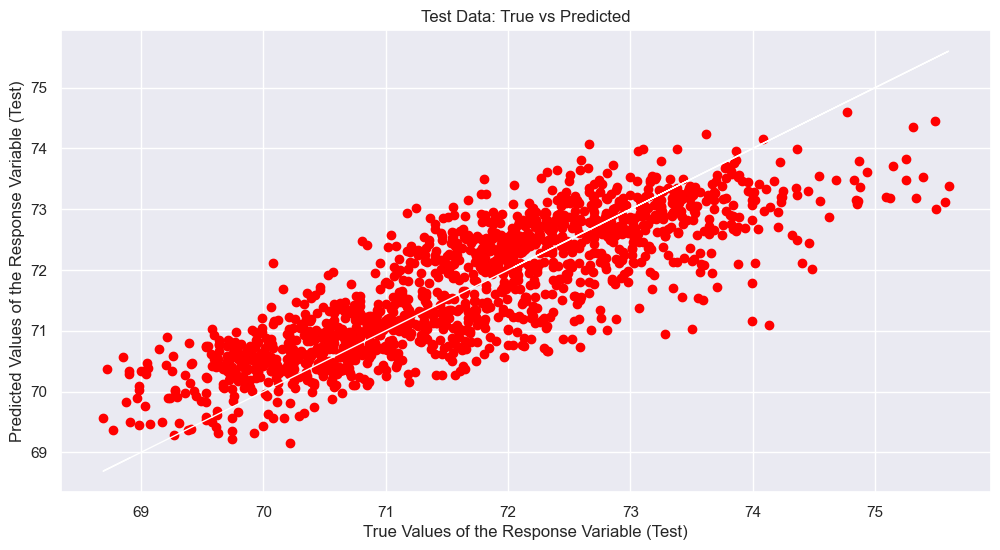

In [764]:
# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# Plot for training data
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_test_pred, color="red")  # Scatter plot of the actual vs predicted
plt.plot(y_test, y_test, 'w-', linewidth=1)  # Line showing the perfect predictions
plt.xlabel("True Values of the Response Variable (Test)")
plt.ylabel("Predicted Values of the Response Variable (Test)")
plt.title("Test Data: True vs Predicted")
plt.show()

## 3.2 Logistic Regression Model

In this analysis, we use Logistic regression to predict the whether a given horse will finish top 3 based on various predictors. Logistic Regression is suitable for this as the result we are predicting is binary. The horse either finishes top 3 or doesn't. Below are the key components and insights from the analysis:

#### Predictors and Response Variable

- **Predictors (X)**: We use the following features as predictors:
  - `encoded_HorseName`: Encoded representation of the horse's name
  - `Barrier`: Barrier number
  - `CarriedWeight`: Weight carried by the horse
  - `Rating`: Horse rating
  - `HorseWeight`: Weight of the horse
  - `encoded_Going`: Encoded representation of track condition (Going)
  - `encoded_Track`: Encoded representation of the track
  - `encoded_Jockey`: Encoded representation of the jockey
  - `encoded_Trainer`: Encoded representation of the trainer

- **Response Variable (y)**: The response variable is `Top3`, representing whether a horse finished Top 3 or not.

#### Data Splitting

- We split the dataset into training and testing sets using a 75/25 ratio.

#### Evaluation

- **Goodness of Fit**:
  - Accuracy Score: measures the proportion of correctly classified instances in the dataset.
  - Confusion Matrix: used to compare the True Positive and False Positive Rates.

#### Insights
- Considering that horse races are highly volatile and hard to predict, an accuracy score of ~0.62 is quite good.
- This is supported by our high True Positive Rate of 65.3%. However, this comes with a tradeoff of a higher False Positive Rate as well. This is because of the highly imbalanced nature of the two classes. A measure we took was to use weighted classes to try to reduce the effect of the large class imbalance.
- However, we have to consider the limitation that we can only predict whether one singular given horse will finish Top 3 or not based on our predictors, and not which 3 horses will finish first given a set of horses.

In [765]:
# First, add a new column into existing dataframe that is encoded win or loss
filtered_df['Top3'] = filtered_df['Placing_Numeric'].isin([1, 2, 3]).astype(int)
filtered_df

C:\Users\Wahaj\AppData\Local\Temp\ipykernel_13204\2679226817.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Top3'] = filtered_df['Placing_Numeric'].isin([1, 2, 3]).astype(int)


,HorseName,encoded_HorseName,Rating,HorseWeight,WeightRatio,Jockey,encoded_Jockey,Trainer,encoded_Trainer,Track_P,Track_T,Placing_Numeric,LBW,FinishTime_Numeric,Top3
10,A BETTER TOMORROW,5.070608,55.0,472.0,0.121822,R WOODWORTH,4.408065,J PETERS,4.632024,0,1,8,12.2,71.74,0
11,A BETTER TOMORROW,5.070608,55.0,470.0,0.122340,R WOODWORTH,4.408065,J PETERS,4.632024,1,0,3,1.0,73.20,1
26,ACE OF DIAMONDS,4.439370,67.0,514.0,0.110895,B QUEIROZ,2.639010,R LE GRANGE,4.312451,0,1,1,1.0,69.57,1
34,ACE OF DIAMONDS,4.439370,46.0,513.0,0.111111,B PINHEIRO,4.233733,R LE GRANGE,4.312451,0,1,1,3.3,70.43,1
45,ACE SOVEREIGN,4.596435,55.0,529.0,0.096408,APP R AZHAR,5.593429,T FITZSIMMONS,4.551032,0,1,6,4.1,69.93,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41114,ZYGARDE,4.019932,48.0,519.0,0.098266,JP VAN DER MERWE,4.871340,KS TAN,5.025140,0,1,2,4.3,70.73,1
41115,ZYGARDE,4.019932,48.0,518.0,0.098456,JP VAN DER MERWE,4.871340,KS TAN,5.025140,0,1,2,0.5,71.21,1
41121,ZYGARDE,4.019932,45.0,520.0,0.108654,S NOH,3.992335,KS TAN,5.025140,0,1,2,1.5,70.68,1
41125,ZYGARDE,4.019932,43.0,529.0,0.110586,M LERNER,4.352045,KS TAN,5.025140,1,0,1,0.5,72.46,1


In [766]:
#predictors
X = filtered_df[predictors]

#response
y = filtered_df['Top3'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
#y_train = np.ravel(y_train)

print("x_train shape :", X_train.shape)
print("y_train shape :", y_train.shape)
print("x_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)

# Initialize and fit logistic regression model
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train, y_train)

x_train shape : (4331, 8)
y_train shape : (4331,)
x_test shape : (1444, 8)
y_test shape : (1444,)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [767]:
# Predict on testing set
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

Training Accuracy: 0.6585084276148695


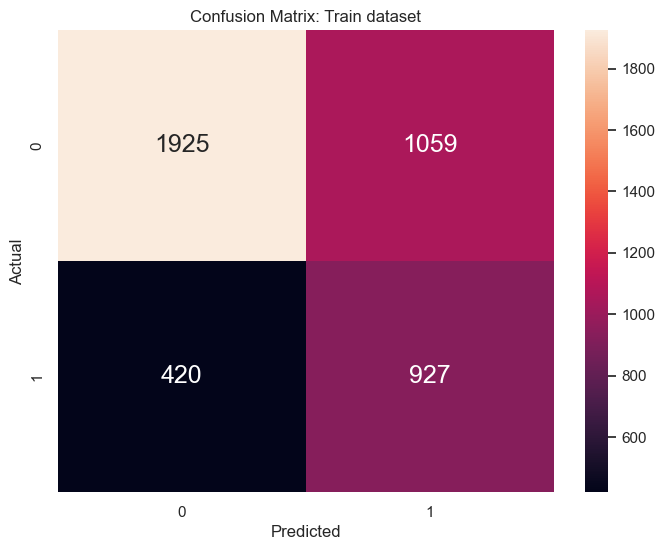

In [768]:
# Calculate accuracy score for training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Plot confusion matrix for Train data set
plt.figure(figsize=(8, 6))
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Train dataset')
plt.show()

From the Confusion Matrix, our **True Positive Rate = 68.8%**, and our **False Positive Rate = 35.5%** for the train dataset.

Testing Accuracy: 0.6295013850415513


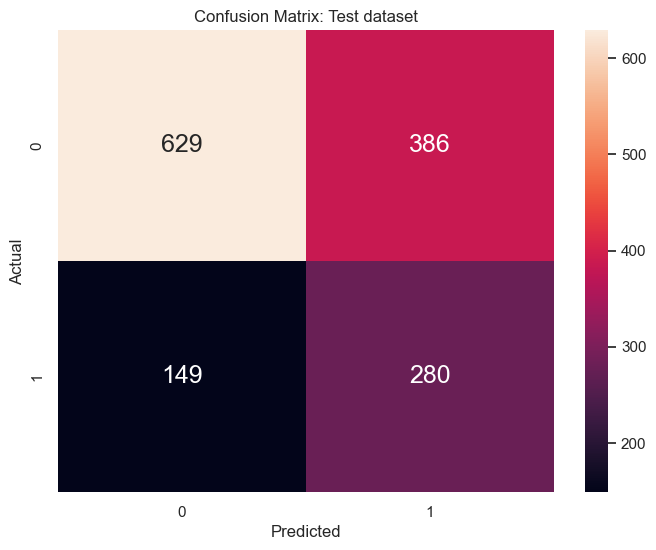

In [769]:
# Calculate accuracy score for testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)


# Plot confusion matrix for Test data set
plt.figure(figsize=(8, 6))
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Test dataset')
plt.show()

Similarly, our **True Positive Rate = 65.3%**, and our **False Positive Rate = 38.0%** for the test dataset.

## 4. Real World Application
### Creating functions to display predictions
- First, we create a function to encode a given dataframe.
- As we have already done the encoding earlier, we only need to map the input with the values. This allows a user to input the HorseName and other race factors without knowing the encoded values beforehand.
- Then we use our functions to display our predictions based on our regression models elegantly.

In [770]:
# Write the encoded values for Jockey to a JSON file
with open('encoded\encoded_jockey.json', 'w') as file:
    jockey_json = filtered_df[['Jockey', 'encoded_Jockey']].drop_duplicates().set_index('Jockey')['encoded_Jockey'].to_dict()
    json.dump(jockey_json, file, indent=4)

# Write the encoded values for Trainer to a JSON file
with open('encoded\encoded_trainer.json', 'w') as file:
    trainer_json = filtered_df[['Trainer', 'encoded_Trainer']].drop_duplicates().set_index('Trainer')['encoded_Trainer'].to_dict()
    json.dump(trainer_json, file, indent=4)

# Write the encoded values for HorseName to a JSON file
with open('encoded\encoded_horse_name.json', 'w') as file:
    horse_json = filtered_df[['HorseName', 'encoded_HorseName']].drop_duplicates().set_index('HorseName')['encoded_HorseName'].to_dict()
    json.dump(horse_json, file, indent=4)

In [771]:
def encoder(dataframe,track):
    # create encoded in dataframe
    with open('encoded\encoded_horse_name.json', 'r') as file:
        horse_dict = json.load(file)
    with open('encoded\encoded_trainer.json', 'r') as file:
        trainer_dict = json.load(file)
    with open('encoded\encoded_jockey.json', 'r') as file:
        jockey_dict = json.load(file)
        
    dataframe['encoded_HorseName'] = dataframe['HorseName'].map(horse_dict)
    dataframe['encoded_Trainer'] = dataframe['Trainer'].map(trainer_dict)
    dataframe['encoded_Jockey'] = dataframe['Jockey'].map(jockey_dict)
    
    dataframe['WeightRatio'] = dataframe['CarriedWeight']/dataframe['HorseWeight']
    
    if track == 'P':
        dataframe['Track_P'] = 1
        dataframe['Track_T'] = 0
    elif track == 'T':
        dataframe['Track_P'] = 0
        dataframe['Track_T'] = 1
    else:
        raise ValueError("Invalid track value. Expected 'P' or 'T'.")

In [772]:
def lin_reg_app(dataframe):
    X = dataframe[predictors]
    y = linreg.predict(X)
    
    predictions_df = pd.DataFrame({
        'HorseName': dataframe['HorseName'],
        'Time': y.flatten()
    })
    # Sort the DataFrame by the 'Time' column
    predictions_df = predictions_df.sort_values('Time')
    
    # Print the sorted DataFrame
    for index, row in predictions_df.iterrows():
        print(f"{row['HorseName']}: {row['Time']:.2f} seconds")

In [773]:
def log_reg_app(dataframe):
    X = dataframe[predictors]
    y = log_reg.predict(X)
    for i in range (0, len(dataframe)):
        print(f"{dataframe.loc[i, 'HorseName']}: {y[i]}")

### Race from 21 Apr 2024
![image of race card](images\racecard.png "21 Apr Race Card")

- We input the race data that was made available to us on race day to attempt to make predictions on horse performance.
- As can be seen below, our Linear Regression model predicted:
    1. DANCING SUPREMO: 70.48 seconds
    2. COOL SIXTY-ONE: 70.58 seconds
    3. STOP THE WATER: 70.60 seconds
- Our Logistic Regression Model predicted multiple different horses to finish top 3, including 'STOP THE WATER' and 'COOL SIXTY-ONE'. It however failed to predict that 'DANCING SUPREMO' would finish top 3.
- In reality, the top 3 horses were:
    1. STOP THE WATER (1:09.47)
    2. COOL SIXTY-ONE (1:09.47)
    3. PACIFIC ATLANTIC (1:09.68)
- As can be seen, predicting finish time or top3 alone is not enough as even a small error can lead to a large difference in results. Hence, we should make our decision based on insights gained from both models.

In [774]:
# Load scraped race day data
with open(r'Race Day Data\21aprildatarace6.json', 'r') as f:
    json_data = json.load(f)

# Create dataframe and add Going and Track columns
RWtest = pd.DataFrame(json_data)

RWtest

,HorseName,Barrier,CarriedWeight,Rating,HorseWeight,Jockey,Trainer
0,STOP THE WATER,13.0,52.5,54.0,474,B QUEIROZ,S BURRIDGE
1,COOL SIXTY-ONE,8.0,54.5,58.0,473,R MAIA,J PETERS
2,PACIFIC ATLANTIC,4.0,55.5,60.0,582,JADEN LLOYD,D KOK
3,DRAGON MASTER,12.0,50.0,48.0,518,APP PH SEOW,J ONG
4,DANCING SUPREMO,1.0,53.5,56.0,511,M NUNES,T FITZSIMMONS
5,BLACKBUCK,3.0,50.0,52.0,508,APP K FAIZ,R LIM
6,GUN,11.0,50.5,50.0,439,C HENRIQUE,D LOGAN
7,PACIFIC GOLD,14.0,54.5,58.0,471,D MOOR,D KOK
8,CITY GOLD WONDER,10.0,57.0,63.0,568,L CORRALES,D KOK
9,WAIT U KNOW,2.0,52.0,51.0,482,B PINHEIRO,R LIM


In [775]:
# Now add the encoded columns
encoder(RWtest,'T')

# We have to drop the row with Silver Star as there is no matching encoding for that particular horse
RWtest = RWtest.dropna()
RWtest = RWtest.reset_index(drop=True)
RWtest

,HorseName,Barrier,CarriedWeight,Rating,HorseWeight,Jockey,Trainer,encoded_HorseName,encoded_Trainer,encoded_Jockey,WeightRatio,Track_P,Track_T
0,STOP THE WATER,13.0,52.5,54.0,474,B QUEIROZ,S BURRIDGE,4.645139,4.760773,2.639010,0.110759,0,1
1,COOL SIXTY-ONE,8.0,54.5,58.0,473,R MAIA,J PETERS,4.372881,4.632024,3.354872,0.115222,0,1
2,PACIFIC ATLANTIC,4.0,55.5,60.0,582,JADEN LLOYD,D KOK,4.841507,5.907361,5.020246,0.095361,0,1
3,DRAGON MASTER,12.0,50.0,48.0,518,APP PH SEOW,J ONG,4.683207,4.603233,4.629630,0.096525,0,1
4,DANCING SUPREMO,1.0,53.5,56.0,511,M NUNES,T FITZSIMMONS,4.504368,4.551032,2.709796,0.104697,0,1
5,BLACKBUCK,3.0,50.0,52.0,508,APP K FAIZ,R LIM,5.140756,5.062547,6.733705,0.098425,0,1
6,GUN,11.0,50.5,50.0,439,C HENRIQUE,D LOGAN,5.084628,4.085523,5.136049,0.115034,0,1
7,PACIFIC GOLD,14.0,54.5,58.0,471,D MOOR,D KOK,4.570103,5.907361,4.076603,0.115711,0,1
8,WAIT U KNOW,2.0,52.0,51.0,482,B PINHEIRO,R LIM,4.578407,5.062547,4.233733,0.107884,0,1
9,SMOKE AND MIRRORS,7.0,52.0,53.0,457,I SAIFUDIN,J ONG,4.200972,4.603233,6.165385,0.113786,0,1


In [776]:
lin_reg_app(RWtest)

DANCING SUPREMO: 70.48 seconds
COOL SIXTY-ONE: 70.58 seconds
STOP THE WATER: 70.60 seconds
PACIFIC GOLD: 70.75 seconds
CON SPERANZA: 70.77 seconds
PACIFIC ATLANTIC: 70.79 seconds
WAIT U KNOW: 70.79 seconds
DRAGON MASTER: 70.80 seconds
SMOKE AND MIRRORS: 70.87 seconds
BLACKBUCK: 71.15 seconds
GUN: 71.17 seconds


In [777]:
log_reg_app(RWtest)

STOP THE WATER: 1
COOL SIXTY-ONE: 1
PACIFIC ATLANTIC: 0
DRAGON MASTER: 1
DANCING SUPREMO: 1
BLACKBUCK: 0
GUN: 0
PACIFIC GOLD: 1
WAIT U KNOW: 1
SMOKE AND MIRRORS: 0
CON SPERANZA: 0
